# Symbolic Regression
This notebook shows how to extract a low dimensional mathematical expression that approximates the committors the `RCModel` learned in the iterative sampling phase.

We will:
1. Load the previous simulation data from the `openpathsampling` storage and load the most recent `RCModel` associated with that simulation
2. Do a HIPR analysis to identify the most relevant coordinates as found by the `RCModel`
3. Use the few most important coordinates as only inputs to the symbolic regression

Note however, that the symbolic regression is not strictly speaken a fit of the `RCModel`, but instead we use the same maximum likeliehood loss function as the `RCModels` to find the most likely reaction coordinate in the reduced space in which the symbolic regression lives. The result is therefore independant of the previously used `RCModel` and we do not introduce any biases through possible overfitting/underfitting in the sampling phase.

In [1]:
%matplotlib inline

In [2]:
import os
import arcd
import numpy as np
import matplotlib.pyplot as plt
import openpathsampling as paths
import openpathsampling.engines.toy as toys
from functools import reduce

Tensorflow/Keras not available


In [3]:
# load a helper class for visualization of the toy system
%run resources/toy_plot_helpers.py

In [4]:
# change to the folder in which we previously sampled
wdir = '/home/think/scratch/SimData_pytorch_toy_22dim/'
if wdir is not None:
    os.chdir(wdir)

## 1. Load what we need from the simulation
- trainset (to be able to calculate the HIPR and to train the symbolic regression on)
- `RCModel` (for HIPR analysis only)
- toy PES for plotting

In [5]:
storage_file = 'pytorch_toy_22dim.nc'
storage = paths.Storage(storage_file, 'r')

In [6]:
toy_eng = storage.engines[0]

In [7]:
stateA = storage.volumes.find('StateA')
stateB = storage.volumes.find('StateB')

In [8]:
pes_list = []
# get the part of the potential that lies in x/y plane for plotting
ow = toy_eng.topology.pes.pes1.pes1.pes1
print('OuterWalls: ', ow)
pes_list.append(ow)

gauss1 = toy_eng.topology.pes.pes1.pes1.pes2
print('gaussian 1: ', gauss1)
pes_list.append(gauss1)

gauss2 = toy_eng.topology.pes.pes1.pes2
print('gaussian 2: ', gauss2)
pes_list.append(gauss2)

# define the energy function for plotting using the previously retrieved parameters
# i.e. the free energy of the system in x/y
def OuterWalls(x):
    return np.sum(pes_list[0].sigma[:2] * (x - pes_list[0].x0[:2])**6, axis=-1)

def GaussA(x):
    return pes_list[1].A * np.exp(np.sum(- pes_list[1].alpha[:2] * (x - pes_list[1].x0[:2])**2, axis=-1))

def GaussB(x):
    return pes_list[2].A * np.exp(np.sum(- pes_list[2].alpha[:2] * (x - pes_list[2].x0[:2])**2, axis=-1))

def V(x):
    return OuterWalls(x) + GaussA(x) + GaussB(x)

OuterWalls:  OuterWalls([0.2 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0. ], [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
gaussian 1:  Gaussian(-0.7000000000000001, [12. 12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.], [-0.75 -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ])
gaussian 2:  Gaussian(-0.7000000000000001, [12. 12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.], [0.75 0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ])


### Plot the toy system energy surface in 2d

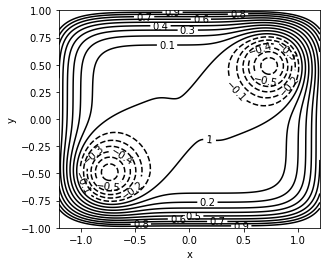

In [9]:
x = np.linspace(-1.2, 1.2, 240)
y = np.linspace(-1., 1., 200)
X, Y = np.meshgrid(x,y)

coord = np.array([[xv, yv] for yv in y for xv in x])
V_val = V(coord)
V_val = V_val.reshape((len(y), len(x)))

fig, axs = plt.subplots(1)
#mapp = axs.imshow(V_val, extent=[x[0], x[-1], y[0], y[-1]], origin='lower')
axs.set_xlabel('x')
axs.set_ylabel('y')
#fig.colorbar(mapp)

levels = np.arange(-1.5 , 1., 0.1)
CS = axs.contour(X, Y, V_val, levels, colors='k')
axs.clabel(CS, inline=1, fontsize=10, )
axs.set_aspect('equal')


### open arcd storage

In [10]:
arcd_storage = arcd.Storage("arcd_storage.h5", "r")

### Load the trainingset 

In [11]:
trainset = arcd_storage.load_trainset()

### Load the model

In [12]:
model = arcd_storage.rcmodels["most_recent"]
model = model.complete_from_ops_storage(storage)

arcd storage passed as density collector cache file is open in read-only mode. No appending will be possible.


## 2. Do a HIPR analysis to find the most relevant input coordinates

In [13]:
hipr = arcd.analysis.HIPRanalysis(model, trainset)
hipr_plus_losses, hipr_plus_std = hipr.do_hipr_plus()

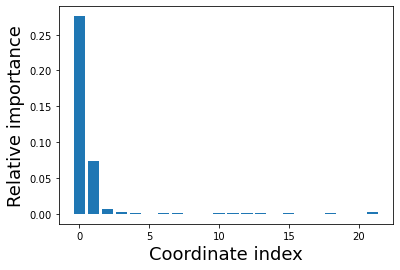

In [14]:
# plot the loss differences
fig, axs = plt.subplots(1)
plt.bar(np.arange(len(hipr_plus_losses)-1), hipr_plus_losses[:-1] - hipr_plus_losses[-1]) 
plt.xlabel('Coordinate index', size=18)
plt.ylabel('Relative importance', size=18);
# Note that this is a bit pointless for the toy system, as we know that only the first two are relevant
# But it is nice to see that the RCmodel thinks so too :)

## 3. Symbolic regression

In [15]:
# necessary imports
import pyaudi
import sympy as sp

In [16]:
# find the most relevant coordinates, i.e. where loss difference is maximal
loss_plus_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]
max_idxs = np.argsort(loss_plus_diffs)[::-1]
print('Most relevant coordinate indices: ', max_idxs)
print('Should have 0, 1 as first two entries for the toy system.')
# get the descriptors and shot results as numpy arrays from the training set
descriptors = trainset.descriptors
shot_results = trainset.shot_results

Most relevant coordinate indices:  [ 0  1  2  3 21 18  4 12  6 13  7 15 11 10  5 14  8 20  9 16 19 17]
Should have 0, 1 as first two entries for the toy system.


In [26]:
n = 2  # lets take the two most relevant inputs for the symbolic regression,
       # i.e. our resulting low dimensional reaction coordinate expression will be of dimension 2
skip = 2  # take only every Nth step to speed up stuff a bit, [should not change the result drastically as subsequent shooting points are correlated anyways]

# create training inputs for symbolic regression
# the training inputs need to be gdual_vdoubles, since we need to be able to calculate gradients w.r.t. them
xt = [pyaudi.gdual_vdouble(descriptors[::skip, i]) for i in max_idxs[:n]]
# the targets can (and should for efficiency) also be numpy arrays, since we need no gradients for them
yt = shot_results[::skip]

# take all points for calculating the test loss
xtf = [pyaudi.gdual_vdouble(descriptors[:, i]) for i in max_idxs[:n]]
ytf = shot_results[:]

In [27]:
# initialize symbolic regression expression with random conectivity and random edge weights
expression = arcd.symreg.initialize_random_expression(n,  # n inputs
                                                      1,  # 1 output: p_B
                                                      kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp'], # potentially allowed elementary mathematical operations
                                                                                                           # our final expression will be a combination of those operations
                                                                                                           # could also add 'sin' and 'sig' for sine and sigmoid
                                                     )

In [28]:
# choose a loss function and a complexity regularization
lossFX = arcd.symreg.losses.binom_loss  # binmial loss for models predicting p_B in a two state system
complex_fx = lambda ex: arcd.symreg.losses.operation_count(ex, fact=0.001)  # operation_count counts the number of elementary mathematical operations in the expression
complex_fx_reduced = lambda ex: arcd.symreg.losses.operation_count(ex, fact=0.0001)  # and multiplies it with factor to get a loss contribution

# there are also other complexity penalties available
# arcd.symreg.losses.active_genes_count : penalizes number of actives genes in the expression
# arcd.symreg.losses.l1_regularization : sparsity regularization on the edge weights
# arcd.symreg.losses.l2_regularization : penalize length of the vector of edge weights (not really a complexity penalty, but sometimes useful)

In [29]:
# here we optimize the expression
lossL = []
genesL = []
weightsL = []
n_iter = 4  # do it n_iter times in a row to get a feeling for the stability of the result
for _ in range(n_iter):
    # initilize a new random expression every time, otherwise we would start the genetic algorithm from the previously optimized individual
    # (which would be the same as running one optimization n_iter times longer)
    expression = arcd.symreg.initialize_random_expression(n, 1, kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp'])
    loss, genes, weights = arcd.symreg.optimize_expression(expression, # expression to optimize
                                                           4,  # number of mutants to create in every generation
                                                           100, # maximum number of generations
                                                           xt,  # training points
                                                           yt,  # training targets, i.e. shot results 
                                                           lossFX,  # either binomial loss for 2 state (predicting only p_B) or multinomial loss for N state
                                                           complexity_regularization=complex_fx,  # the combined lambda function(s) we use for complexity regularization
                                                                                                  # all of these do not need gradients w.r.t the weights
                                                           weight_regularization=None,  # combined lambda functions for weight regularizations
                                                                                        # these need and calculate the gradients w.r.t. edge weights
                                                           newtonParams={'steps':100},  # newton steps is what makes up most of the runtime,
                                                                                        # however if it is to small expressions will not converge in parameter space
                                                                                        # this can be diagnosed if we have many similar expression with different coeffs
                                                          )
    # store loss, genes and weights of the best expression found in every round
    lossL.append(loss)
    genesL.append(genes)
    weightsL.append(weights)

In [30]:
# print the resulting equations for every round
for l, g, w in zip(lossL, genesL, weightsL):
    # we take a dummy expression and set it to the optimal parameters we found previously
    expression.set(g)  # set genes to the best we found
    expression.set_weights(w)  # also set edge weights of the expression
    print('loss with regularization on training data: ', l)  # this is the loss we had in training, includes all regularizations and is calculated only over the reduced dataset
    print('losss without regularization on all data: ', sum(lossFX(expression, xtf, ytf).constant_cf))  # this is the loss of the expression on the full dataset without regularizations
                                                                                                        # i.e. the actual likeliehood
    print(expression.simplify(['x{:d}'.format(idx) for idx in max_idxs[:n]], subs_weights=True))  # print the formula, subsitute edge weights to numbers
    print()

loss with regularization on training data:  0.5560986785603094
losss without regularization on all data:  0.560473147009261
[3.01688072286304*x0 + 1.95665460233872*x1]

loss with regularization on training data:  0.5560986785603094
losss without regularization on all data:  0.5604731470092645
[3.01688072286421*x0 + 1.9566546023397*x1]

loss with regularization on training data:  0.5558466611255113
losss without regularization on all data:  0.567939694054939
[x0*(3.08794194963309*x1 - 0.00785738733725361)/x1 + 1.99091149496355*x1]

loss with regularization on training data:  0.5558466611255115
losss without regularization on all data:  0.567939694054933
[x0*(3.08794194963378*x1 - 0.00785738733725492)/x1 + 1.99091149496178*x1]



### Plot the committor predicted by the symbolic regression expression onto the potential

In [31]:
# Note that since the symbolic regression predicts log_probabilities we will need to take the sigmoid to get p_B
# we use scipy for that
from scipy.special import expit as sigmoid

Chose expression with index 2 for plotting, because it has the lowest loss.


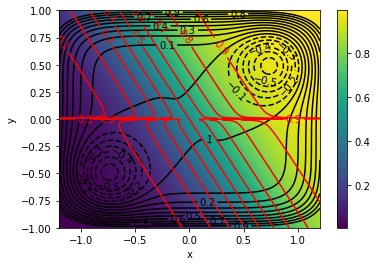

In [32]:
# choose an expression to plot and get the weights + genes we stored
expr_idx = np.argmin(lossL)
print(f"Chose expression with index {expr_idx} for plotting, because it has the lowest loss.")
genes = genesL[expr_idx]
weights = weightsL[expr_idx]
# set genes and weights as above
expression.set(genes)
expression.set_weights(weights)

# genereate the energy surface plotting data
x = np.linspace(-1.2, 1.2, 240)
y = np.linspace(-1., 1., 200)
X, Y = np.meshgrid(x,y)
# create an array of coordinate value pairs to calculate V(x,y)
# do it as one big 1d array as it is much faster
coord = np.array([[xv, yv] for yv in y for xv in x])
V_val = V(coord)
# unwrap to a 2d array for plotting
V_val = V_val.reshape((len(y), len(x)))

# actual plotting
fig, axs = plt.subplots(1)
axs.set_xlabel('x')
axs.set_ylabel('y')

# plot isolines of the energy surface
levels = np.arange(-1.5 , 1., 0.1)
CS = axs.contour(X, Y, V_val, levels, colors='k')
axs.clabel(CS, inline=1, fontsize=10, )
axs.set_aspect('equal')

# generate RC plotting data
coord_gdual = [pyaudi.gdual_vdouble(coord[:, i]) for i in range(coord.shape[1])]
rc = expression(coord_gdual)  # this is now a list of gdual_vdoubles
# since we trained with the binomial loss the RC only has one entry, the RC towards B
rc = np.array(rc[0].constant_cf) # convert to a numpy array, i.e. take only the values and ignore the higher order derivates
# again unwrap to 2d array for plotting
rc_mat = rc.reshape((len(y), len(x)))

# actual plotting
# first as color gradient
mapp = axs.imshow(sigmoid(rc_mat), extent=[x[0], x[-1], y[0], y[-1]], origin='lower')
# also plot isolines of p_B in red
levels = np.arange(0. , 1., 0.1)
CS = axs.contour(X, Y, sigmoid(rc_mat), levels, colors='r')
axs.clabel(CS, inline=1, fontsize=10, )
# draw a colorbar
fig.colorbar(mapp)